# Image Preparation Lab

In [59]:
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
PATH = "data/raw/CBIS-DDSM/Calc-Test_P_00041_LEFT_CC/08-29-2017-DDSM-52275/1.000000-full mammogram images-92812/1-1.dcm"
GLOBAL_THRESHOLD = 18
LABEL_VALUE = 255
FILL_HOLES = True
SMOOTH_BOUNDARY = True
KERNEL_SIZE = 15
IMG_SIZE = (256,256)

## Raw Image

(5664, 3984)

array([[65535, 65535, 65535, ..., 61295, 61361, 61273],
       [65535, 65535, 65535, ..., 61427, 61295, 61317],
       [65535, 65535, 65535, ..., 61427, 61229, 61207],
       ...,
       [61427, 44651, 43594, ..., 61141, 61251, 61207],
       [61956, 46038, 44298, ..., 61383, 61141, 61251],
       [62110, 48416, 47249, ..., 61494, 61185, 61119]], dtype=uint16)

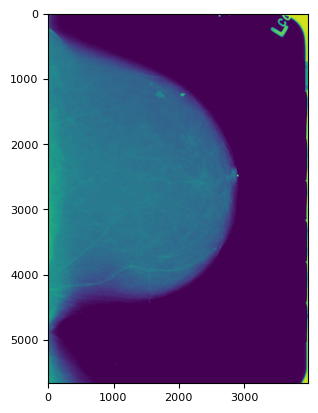

In [61]:
dataset = pydicom.dcmread(PATH)
img = dataset.pixel_array
img.shape
img
plt.imshow(img)

## Artifact Removal

### Normalize

In [62]:
def normalize_to_255(img):
    if img.max() != 0:
        img = img / img.max()
    img *= 255
    return img.astype(np.uint8)

### Binary Masking

In [63]:
def binarize(img):
    _, img_bin = cv2.threshold(img, 0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
    return img_bin

### Largest Object Selection

In [64]:
def extract_contour(bin_img):
    contours, _ = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    return contour

In [65]:
def erase_background(img, contour):
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    output = cv2.bitwise_and(img, mask)
    return output

In [55]:
def crop(contour):
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = int(0.99 * x1), int(1.01 * x2)
    y1, y2 = int(0.99 * y1), int(1.01 * y2)
    return img[y1:y2, x1:x2]    


In [66]:
def resize(img):
    return cv2.resize(img, IMG_SIZE)

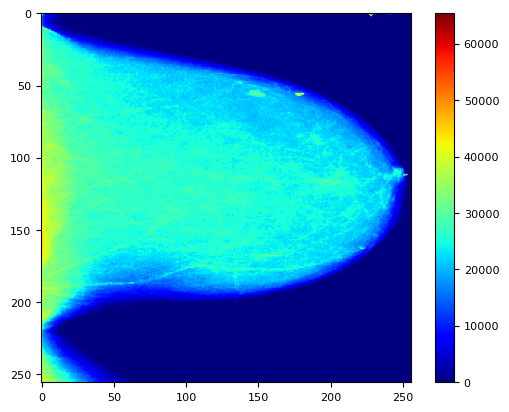

In [67]:
img_norm = normalize_to_255(img)
img_bin = binarize(img_norm)
contour = extract_contour(img_bin)
img_crop = crop(contour)
img_clean = resize(img_crop)
plt.imshow(img_clean, cmap='jet')
plt.colorbar()
plt.show()